### Clase 5: Laboratorio

Resultado de atención: [[2.]]
Resultado de auto-atención: tensor([[[0.8022, 0.5989],
         [0.5989, 0.8022],
         [0.7517, 0.7517]]])


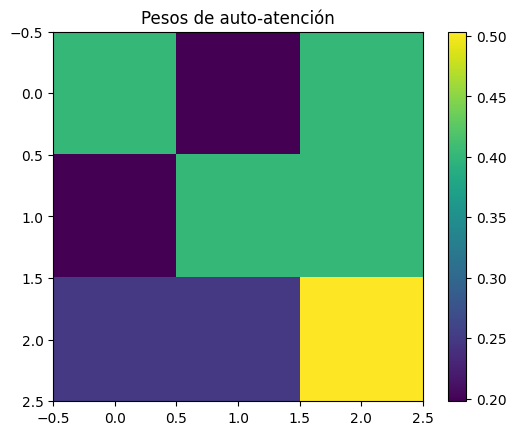

Forma del vector de contexto: torch.Size([1, 1, 16])
Texto generado: La teoría de la relatividad establece que la energía de una partícula se propaga por una fuerza de gravedad de la gravedad a través del espacio-tiempo. El espacio-tiempo se propaga de la misma manera que el espacio-tiempo. La teoría de la relatividad establece que las leyes de la mecánica clásica son equivalentes a las leyes de la relatividad.

La relatividad general describe el espacio-tiempo como una unidad de medida que tiene un valor constante en el tiempo. La densidad de la velocidad del espacio-tiempo es la misma para todos los tiempos, excepto para el caso de la velocidad de los objetos que no son objetos. La densidad de la energía del espacio-tiempo puede calcularse con una precisión de 10 a 100 veces más rápido que en el tiempo. La velocidad de la luz es la misma para todos los períodos. La densidad de la luz es similar para todos los períodos de tiempo. La fuerza de gravedad es la misma para todas las partíc

'\n- La atención pondera dinámicamente los tokens de entrada según su relevancia.\n- La auto-atención permite que cada token atienda a todos los demás.\n- La atención multi-cabeza proyecta en múltiples subespacios.\n- Los transformers apilan capas con bloques de atención y feedforward.\n- Los LLMs modernos como GPT usan transformers para modelado y generación de secuencias.\n- Entrenamos un modelo transformer pequeño para demostrar el aprendizaje secuencial.\n'

In [7]:
# # Understanding Attention Mechanisms and Transformers

# ## 1. Introduction

"""
Este cuaderno introduce y explora los conceptos de atención, auto-atención,
atención multi-cabeza y transformadores. Estos mecanismos forman la base
de los modelos modernos de PLN como BERT, GPT y T5. Comenzaremos desde los conceptos
básicos y culminaremos en una implementación mínima de un codificador transformer con ejemplos.
"""

# ## 2. The Attention Mechanism

import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt

# ### 2.1. Basic Attention (Single Query)

def attention(query, key, value):
    d_k = query.shape[-1]
    scores = np.dot(query, key.T) / np.sqrt(d_k)
    weights = np.exp(scores) / np.sum(np.exp(scores), axis=-1, keepdims=True)
    return np.dot(weights, value)

# Example
q = np.array([[1, 0]])
k = np.array([[1, 0], [0, 1], [1, 1]])
v = np.array([[1], [2], [3]])
print("Resultado de atención:", attention(q, k, v))

# ### 2.2. Toy Exercise
# Calcular atención manualmente para Q = [1, 0], keys = [[1, 0], [0, 1]], values = [[10], [20]]

# ## 3. Self-Attention

X = torch.tensor([[1.0, 0.0], [0.0, 1.0], [1.0, 1.0]])  # 3 tokens, embedding de 2 dimensiones
X = X.unsqueeze(0)  # Añadir dimensión de batch

def self_attention(X):
    d_k = X.size(-1)
    Q = K = V = X
    scores = torch.matmul(Q, K.transpose(-2, -1)) / d_k**0.5
    weights = F.softmax(scores, dim=-1)
    return torch.matmul(weights, V)

print("Resultado de auto-atención:", self_attention(X))

# ### 3.1. Visualizing Attention Maps

weights = F.softmax(torch.matmul(X, X.transpose(-2, -1)) / np.sqrt(2), dim=-1)
plt.imshow(weights[0].detach(), cmap='viridis')
plt.title("Pesos de auto-atención")
plt.colorbar()
plt.show()

# ## 4. Multi-Head Attention

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0
        self.d_k = d_model // num_heads
        self.num_heads = num_heads

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

    def forward(self, x):
        B, T, C = x.size()
        Q = self.W_q(x).view(B, T, self.num_heads, self.d_k).transpose(1, 2)
        K = self.W_k(x).view(B, T, self.num_heads, self.d_k).transpose(1, 2)
        V = self.W_v(x).view(B, T, self.num_heads, self.d_k).transpose(1, 2)

        scores = torch.matmul(Q, K.transpose(-2, -1)) / self.d_k**0.5
        weights = F.softmax(scores, dim=-1)
        heads = torch.matmul(weights, V)

        concat = heads.transpose(1, 2).contiguous().view(B, T, C)
        return self.W_o(concat)

# ## 5. Transformer Block

class TransformerBlock(nn.Module):
    def __init__(self, d_model, num_heads, ff_hidden_dim):
        super().__init__()
        self.attn = MultiHeadAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.ff = nn.Sequential(
            nn.Linear(d_model, ff_hidden_dim),
            nn.ReLU(),
            nn.Linear(ff_hidden_dim, d_model)
        )
        self.norm2 = nn.LayerNorm(d_model)

    def forward(self, x):
        x = self.norm1(x + self.attn(x))
        x = self.norm2(x + self.ff(x))
        return x

# ## 6. Prompt Completion with Seq2Seq + Attention

"""
Ahora ilustraremos cómo la atención ayuda en la traducción secuencia a secuencia.
Ejemplo: traduciendo "je suis etudiant" → "I am a student"
Simulamos las interacciones entre codificador y decodificador.
"""

encoder_outputs = torch.rand(1, 4, 16)
decoder_hidden = torch.rand(1, 1, 16)

scores = torch.matmul(decoder_hidden, encoder_outputs.transpose(-2, -1)) / np.sqrt(16)
weights = F.softmax(scores, dim=-1)
context = torch.matmul(weights, encoder_outputs)

print("Forma del vector de contexto:", context.shape)

# ## 7. Prompt Completion with Transformer

"""
Usando transformadores preentrenados como BERT o GPT, podemos completar prompts
tokenizando el input, pasándolo por el modelo y decodificando la salida.
"""

from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("datificate/gpt2-small-spanish")
model = AutoModelForCausalLM.from_pretrained("datificate/gpt2-small-spanish")

prompt = "La teoría de la relatividad establece que"
inputs = tokenizer(prompt, return_tensors="pt")

output_ids = model.generate(
    inputs["input_ids"],
    attention_mask=inputs["attention_mask"],
    pad_token_id=tokenizer.eos_token_id,
    max_length=300,
    do_sample=True,
    top_k=10,
    top_p=0.95,
    temperature=0.9
)

print("Texto generado:", tokenizer.decode(output_ids[0], skip_special_tokens=True))


# ## 8. Train a Toy Transformer with Multi-Head Attention

"""
Ahora entrenaremos un modelo transformer pequeño en una tarea sintética:
reconstruir una secuencia de enteros desplazados (aprendizaje de identidad).
"""

class ToyTransformer(nn.Module):
    def __init__(self, vocab_size, d_model, num_heads, ff_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.encoder = TransformerBlock(d_model, num_heads, ff_dim)
        self.decoder = nn.Linear(d_model, vocab_size)

    def forward(self, x):
        x = self.embedding(x)
        x = self.encoder(x)
        return self.decoder(x)

# Crear datos sintéticos
def generate_data(seq_len=6, batch_size=32, vocab_size=10):
    x = torch.randint(1, vocab_size, (batch_size, seq_len))
    y = x.clone()
    return x, y

# Entrenar el modelo
d_model, num_heads, ff_dim, vocab_size = 16, 2, 64, 10
model = ToyTransformer(vocab_size, d_model, num_heads, ff_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

for step in range(300):
    x, y = generate_data()
    logits = model(x)
    loss = loss_fn(logits.view(-1, vocab_size), y.view(-1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if step % 50 == 0:
        print(f"Paso {step}, pérdida: {loss.item():.4f}")

# Probar el modelo
x, y = generate_data(batch_size=1)
preds = model(x).argmax(dim=-1)
print("Secuencia de entrada:", x.tolist())
print("Secuencia esperada:", y.tolist())
print("Predicción del modelo:", preds.tolist())

# ## 9. Summary
"""
- La atención pondera dinámicamente los tokens de entrada según su relevancia.
- La auto-atención permite que cada token atienda a todos los demás.
- La atención multi-cabeza proyecta en múltiples subespacios.
- Los transformers apilan capas con bloques de atención y feedforward.
- Los LLMs modernos como GPT usan transformers para modelado y generación de secuencias.
- Entrenamos un modelo transformer pequeño para demostrar el aprendizaje secuencial.
"""

# ## 10. Further Reading
# - Vaswani et al. (2017): Attention is All You Need
# - Jay Alammar: The Illustrated Transformer
# - Documentación de HuggingFace Transformers
